# Data Mining - First Home Assignment

## Group 13

### Alexandre Sobreira 59451 | André Dias 59452 |  Tiago Rodrigues 49593

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import matthews_corrcoef, confusion_matrix, accuracy_score, explained_variance_score, max_error
from scipy.stats import pearsonr
from sklearn.naive_bayes import GaussianNB

In this assignment, two data files were given ("train.csv"; "unique_m.csv"). Both these data files contain independent variables that can be used to predict the same dependent variable ("critical_temp"). With the objective of performing both PCA and SVD and comparing their results, a single dataset was created ("fused" dataset), which consisted in the concatenation of the individual data files (since the rows referenced the same sample). This fused dataset was created with the division into independent and dependent variables in mind (data_fused_X for independent variables and data_fused_y for the dependent variable).

Since different independent variables had distinct measures and standard deviation, the data should be scaled. Initially, data_fused_X and data_fused_y were split into training and test sets. Following this, the scikit standard scaler was used to fit the training data and then scale the data of the training and test sets.

In [2]:
# Read data 
data_train = pd.read_csv('train.csv')
data_unique = pd.read_csv('unique_m.csv')
# Create fused dataset
data_fused_X = np.array(pd.concat([data_train.copy().drop('critical_temp', axis = 1), data_unique.copy().drop(['critical_temp', 'material'], axis=1)], axis = 1))
data_fused_y = np.array(data_train['critical_temp'].copy())
# Scaling
data_fused_X_train, data_fused_X_test, data_fused_y_train, data_fused_y_test = train_test_split(data_fused_X, data_fused_y, test_size = 0.1, random_state = 42)
scaler = StandardScaler()
scaler.fit(data_fused_X_train)
data_fused_X_train_scaled = scaler.transform(data_fused_X_train)
data_fused_X_test_scaled = scaler.transform(data_fused_X_test)

# Objective 1

With the purpose of comparing both dimensionality reduction methodologies (PCA and SVD), these were applied separately to the data:

## PCA

In PCA, the goal is to create principal components, which are linear combinations of the independent variables, that explain a certain threshold of the variance of the data (typically 90%). With this in mind, the number of principal components required to obtain a total variance explained of 0.9 was tested:

In [3]:
n_comps = 100
W, v = np.linalg.eig(data_fused_X_train_scaled.T @ data_fused_X_train_scaled)
vexp = W/W.sum()
tve = 0
stopper = 0
for i, ve in enumerate(vexp[:n_comps]):
    tve+=ve
    if tve >= 0.9 and stopper == 0:
        print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve))
        chosen_pcs = i
        stopper += 1

PC75 - Variance explained:  0.0017 - Total Variance:  0.9006


As seen in the results above, a total of 76 principal components are required to explain 90% of the total data variance (indicates 75 but PC0 exists, making it 76). In PCA, the data is then transformed to this new dimensional space with only 76 independent variables.

In [4]:
# Based on the result above we should keep 76 principal components as they explain 90.8% of the data variance
data_fused_X_train_PCA = data_fused_X_train_scaled @ v[:76,:].T
data_fused_X_test_PCA = data_fused_X_test_scaled @ v[:76,:].T

With this transformation, the total number of independent variables was diminished from the initial 167 to only 76, while maintaining the 90 % of the total data variance.

## SVD

In SVD, the goal will be to identify the most significant components of the data and discard the rest, functioning as a sort of noise reduction methodology.

Initially, the u, s and v matrixes have to be created based on the training set. Then, the importance of the several components is analised and a given number of components is kept when a combined importance threshold is reached (typically 0.9).

In [5]:
u, s, v = np.linalg.svd(data_fused_X_train_scaled)
np.set_printoptions(precision = 3)
np.set_printoptions(suppress = True)
stopper = 0
for i in range(len(s)):
    if s[:i+1].sum()/s.sum() >= 0.9 and stopper == 0:
        print("First %d components have a combined importance of %7.4f" %(i+1, s[:i+1].sum()/s.sum()))
        stopper += 1

First 90 components have a combined importance of  0.9007


From the results above, it's possible to verify that 90 components break the combined importance threshold. As such, each of the matrixes (u, s and v) have to be adjusted for this number of components. Following this, the original training dataset is regenerated from these simplified u, s and v matrixes.

In [6]:
# keep 90 components
U = u[:, :90]
S = np.diag(s[:90])
V = v[:90, :]
data_fused_X_train_SVD = U @ S @ V
data_fused_X_test_SVD = data_fused_X_test_scaled

The results obtained from SVD will be a new data_fused_X_train, which hopefully will have less noisy data that can result in better models.

# Objective 2

# 2.1. Regression Models

The main objective of 2.1 is to make a regression model, for the previosly obtained datasets, using either the Linear Regression or Decision Tree regression model. However, it was decided to make both models to gain a better understanding of how they perform and how they differ from each other. This is a good approach because it allows for a better comparison of the strengths and weaknesses of each model and choose the one that is most suitable for this specific problem.
For the purpose of getting a better understanding of the performance of these models several regression statistics were performed to evaluate each of the models. The following function was designed to return not only a dataframe containing several of regression statistics, namely, the Explained Variance Score (RVE), correlation (corr) and the max error (max_err) of each of the regression models, but also a truth predicted plot which is a graph that shows the relationship between the true values and the predicted values of a model.


In [7]:
def regression_statistics(truth_scaled, preds_scaled, truth_pca, preds_pca, truth_svd, preds_svd):
    # Define the data types
    data_types = ['Fused', 'PCA-Transformed', 'SVD-Transformed']
    # Initialize lists to store the results
    rve_list, corr_list, max_err_list = [], [], []
    # Loop over each data type and calculate the regression statistics
    for i, data_type in enumerate(data_types):
        if data_type == 'Fused':
            truth, preds = truth_scaled, preds_scaled
        elif data_type == 'PCA-Transformed':
            truth, preds = truth_pca, preds_pca
        else:
            truth, preds = truth_svd, preds_svd
        rve = explained_variance_score(truth, preds)
        corr = pearsonr(truth, preds)
        max_err = max_error(truth, preds)
        # Append the results to the corresponding lists
        rve_list.append(rve)
        corr_list.append(corr)
        max_err_list.append(max_err)
    # Store the results in a dataframe
    data = {'Data Type': data_types, 'Explained Variance Score': rve_list, 'Correlation': corr_list, 'Max Error': max_err_list}
    df = pd.DataFrame(data)
    # Print the dataframe and plot the results for each type of data
    print(df)
    # Create a figure with subplots for each type of data
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # Loop over each data type and create a scatter plot of the truth vs. predicted values
    for i, data_type in enumerate(data_types):
        if data_type == 'Fused':
            truth, preds = truth_scaled, preds_scaled
        elif data_type == 'PCA-Transformed':
            truth, preds = truth_pca, preds_pca
        else:
            truth, preds = truth_svd, preds_svd
        # Create the scatter plot
        axs[i].scatter(truth, preds)
        axs[i].plot([min(truth), max(truth)], [min(truth), max(truth)], 'r--')
        axs[i].set_xlabel('Truth')
        axs[i].set_ylabel('Predicted')
        axs[i].set_title(data_type)
    # Adjust the layout of the subplots
    fig.tight_layout()
    # Show the plot
    plt.show()

## Linear Regression

         Data Type  Explained Variance Score  \
0            Fused              7.656107e-01   
1  PCA-Transformed              6.755505e-01   
2  SVD-Transformed             -6.424011e+19   

                                  Correlation     Max Error  
0                   (0.8749918999053408, 0.0)  6.937266e+01  
1                   (0.8220219999754312, 0.0)  1.699643e+02  
2  (0.006902589833898921, 0.7503635524762862)  2.675198e+12  


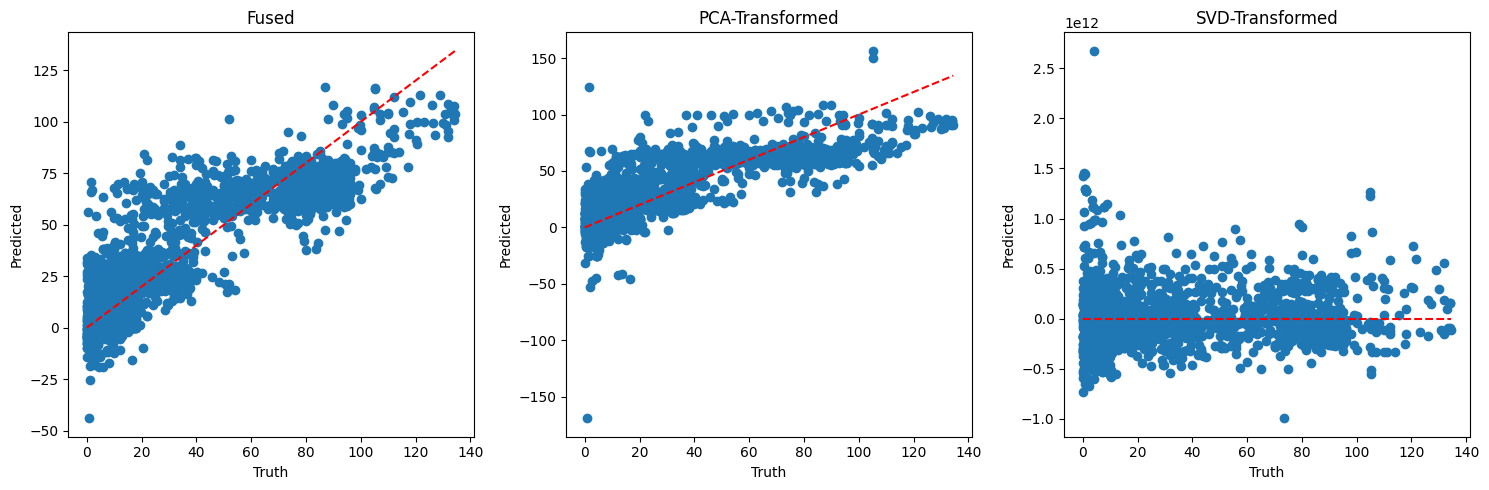

In [8]:
model_scaled = LinearRegression().fit(data_fused_X_train_scaled, data_fused_y_train)
y_pred_scaled = model_scaled.predict(data_fused_X_test_scaled)
model_pca = LinearRegression().fit(data_fused_X_train_PCA, data_fused_y_train)
y_pred_pca = model_pca.predict(data_fused_X_test_PCA)
model_svd = LinearRegression().fit(data_fused_X_train_SVD, data_fused_y_train)
y_pred_svd = model_svd.predict(data_fused_X_test_SVD)
results_scaled = regression_statistics(data_fused_y_test, y_pred_scaled, data_fused_y_test, y_pred_pca, data_fused_y_test, y_pred_svd)

The results show that the regression model for the fused data performs better than the model for the PCA-transformed data or the SVD-transformed data in most performance metrics.

- The Explained Variance Score (RVE) is higher for the fused data (0.766 for fused data, 0.676 for PCA-transformed data and very high negative values for the SVD-transformed data), indicating that the model explains a larger proportion of the variance in the data for the fused data than for the PCA-transformed data and that the SVD-transformed data leads to a very bad model.

- The Correlation coefficient is higher for the fused data (0.875 for fused data, 0.822 for PCA-transformed data and 0.007 for the SVD-transformed data), indicating that there is a stronger linear relationship between the predicted and true values for the fused data than for the PCA-transformed data and that for the SVD-transformed data the correlation is almost non-existent.

- The Max Error is lower for the fused data (69.373 for fused data, 169.964 for PCA-transformed data and 2.67e+12 for the SVD-transformed data), indicating that the largest prediction error is smaller for the fused data than for the PCA-transformed data. Once, again, the SVD-transformed data led to the worst results, with a very high max error.

An interesting find was that the transformation performed by SVD on the fused data resulted in weak performance metrics and the truth predicted plot does not show a linear relationship showing that the predicted values are substancialy different from the true values. One of the reasons why PCA performed better than SVD could be that PCA requires the input variables to be centered (i.e., subtracted by their mean), while SVD does not have this requirement. Additionally, PCA forces the extracted principal components to be orthogonal to each other, while SVD does not. This orthogonality constraint can help to reduce the impact of noise and irrelevant features in the data, which may have contributed to the better performance of PCA. Another difference between PCA and SVD is that PCA extracts principal components that capture the maximum variance in the data, while SVD decomposes the data into three matrices that capture the covariance structure of the data. The maximum variance capturing property of PCA may have helped to identify the most important features in the data, leading to better performance in the regression model. Lastly, SVD has seen better applications when the input data is sparse, which is not the case for the "train.csv" independent variables.

Overall, these results suggest that the model built using the fused data without any dimenstionality reduction performs better than the model built using the PCA and SVD-transformed data. Nevertheless, PCA-reduced data's results were not far behind the fused dataset, which is indicative of its strength in maintaining the data variance while greatly reducing its dimensionality.

## Decision Tree Regression

         Data Type  Explained Variance Score                Correlation  \
0            Fused                  0.894385  (0.9467667342573707, 0.0)   
1  PCA-Transformed                  0.851740  (0.9249850539143354, 0.0)   
2  SVD-Transformed                  0.636234    (0.82236347294801, 0.0)   

   Max Error  
0      118.9  
1      112.9  
2       99.9  


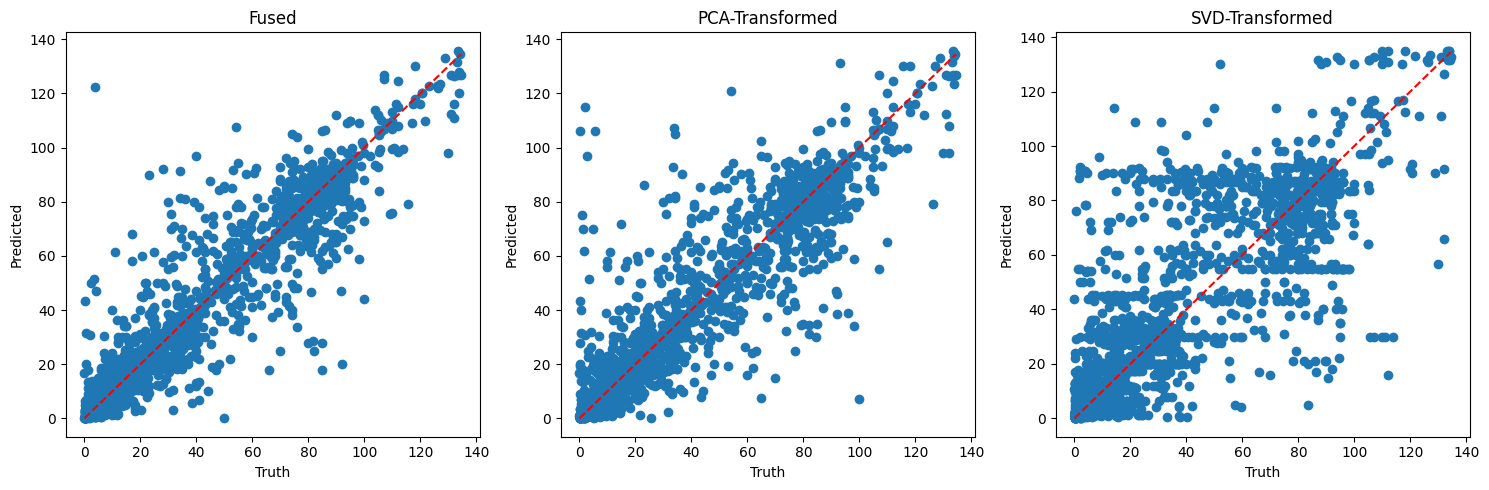

In [9]:
model_scaled = DecisionTreeRegressor(random_state = 2023).fit(data_fused_X_train_scaled, data_fused_y_train)
y_pred_scaled = model_scaled.predict(data_fused_X_test_scaled)
model_pca = DecisionTreeRegressor(random_state = 2023).fit(data_fused_X_train_PCA, data_fused_y_train)
y_pred_pca = model_pca.predict(data_fused_X_test_PCA)
model_svd = DecisionTreeRegressor(random_state = 2023).fit(data_fused_X_train_SVD, data_fused_y_train)
y_pred_svd = model_svd.predict(data_fused_X_test_SVD)
results_scaled = regression_statistics(data_fused_y_test, y_pred_scaled, data_fused_y_test, y_pred_pca, data_fused_y_test, y_pred_svd)

The results show that the decision tree regression model for the fused data performs better than the model for the PCA-transformed data or the SVD-transformed data in most performance metrics.

- The Explained Variance Score (RVE) is higher for the fused data (0.894 for fused data, 0.852 for PCA-transformed data and 0.636 for the SVD-transformed data), indicating that the model explains a larger proportion of the variance in the data for the fused data than for the PCA-transformed data or the SVD-transformed data.

- The Correlation coefficient is higher for the fused data (0.947 for fused data, 0.925 for PCA-transformed data and 0.822 for the SVD-transformed data), indicating that there is a stronger linear relationship between the predicted and true values for the fused data than for the PCA-transformed data or the SVD-transformed data.

- The Max Error is higher for the fused data (118.9 for fused data, 112.9 for PCA-transformed data and 99.9 for the SVD-transformed data), indicating that the largest prediction error is higher for the fused data than for the PCA-transformed data or the SVD-transformed data.

Overall, these results suggest that the model built using the fused data without any dimenstionality reduction performs better than the model built using the PCA and SVD-transformed data.

After analyzing the results of both models (Linear Regression and Decision Tree Regression), it was found that the Decision Tree Regression applied to the fused dataset (without dimensionality reduction) returned the best performance metrics. One possible explanation for this is that the data has a non-linear relationship, which may cause the linear regression model to perform poorly in comparison to the decision tree regression. Additionally, linear regression is sensitive to outliers, which can significantly affect the model's predictions, whereas decision tree regression partitions the data into smaller subsets based on the input variables, reducing the impact of outliers on the model's predictions. Another important observation is that the model obtained using the SVD-transformed data was much better when using Decision Tree Regression and actually resulted in the model with the least maximum error, which could be indicative of this technique's strength to reduce noise in data, which could be seen as outlier supression.

# 2.2. Classification Models

The main objective of 2.2 is to make a classification model, for the previosly obtained datasets, using either the Naive Bayes (Gaussian was chosen, given that the Independent variables are continuos) or Decision Tree Classification model. It was decided to make both models to gain a better understanding of how they perform and how they differ from each other. This is a good approach because it allows for a better comparison of the strengths and weaknesses of each model and choose the one that is most suitable for this specific problem.
For the purpose of getting a better understanding of the performance of these models several classification statistics were performed to evaluate each of the models. The following classification metrics were used: the Accuracy (Acc), Matthews Correlation Coeficient (MCC) and also the confusion matrix, which allows to evaluate each model's misclassifications.

Since the dependent variable of the provided dataset is continous, it needs to be transformed into classes. This discretization was made according to the classes defined in the assignment:

In [10]:
#For the classification Models the dependent variable ("critical_temp") needs to be transformed into classes.
bins = [0.0, 1.0, 5.0, 20.0, 100.0, float('inf')]
labels = ['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh']
data_fused_y_classes = pd.cut(data_fused_y, bins=bins, labels=labels, include_lowest=True)

In [11]:
data_fused_y_classes.describe()
# Data seems to be unbalanced

,counts,freqs
categories,,
VeryLow,1036,0.048723
Low,4057,0.190801
Medium,5623,0.264450
High,9779,0.459907
VeryHigh,768,0.036119


As seen in the results above, this dataset is quite unbalenced, which is indicative that the Matthews Correlation Coeficient will be a better metric for evaluating the models' quality.

The dataset has to be splitted once again, now using this data_fused_y_classes:

In [12]:
#split and scale for fused dataset with y as classes
data_fused_X_train, data_fused_X_test, data_fused_y_train_classes, data_fused_y_test_classes = train_test_split(data_fused_X, data_fused_y_classes, test_size = 0.1, random_state = 42)
scaler = StandardScaler()
scaler.fit(data_fused_X_train)
data_fused_X_train_scaled = scaler.transform(data_fused_X_train)
data_fused_X_test_scaled = scaler.transform(data_fused_X_test)

A function was then made to fit, predict and evaluate the models, whose parameters were maintained as default which can be seen in sklearn documentation.

In [13]:
# Function for fit, predict and metrics
def models (X_train, y_train, X_test, y_test, dataset):
    models = [DecisionTreeClassifier(random_state = 2023), GaussianNB()]
    for model in models:
        print(str(model) + dataset)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print(confusion_matrix(y_test, preds))
        print("The global accuracy is: %7.4f" % accuracy_score(y_test, preds))
        print("The global MCC is: %7.4f" % matthews_corrcoef(y_test, preds))
        print("")

### Full fused Dataset

In [14]:
models(data_fused_X_train_scaled, data_fused_y_train_classes, data_fused_X_test_scaled, data_fused_y_test_classes, " -> Full fused dataset")

DecisionTreeClassifier(random_state=2023) -> Full fused dataset
[[909   3  56  12   0]
 [  6 321  50   0  24]
 [ 65  64 447   0   6]
 [  9   0   0  53   0]
 [  2  21   7   0  72]]
The global accuracy is:  0.8472
The global MCC is:  0.7733

GaussianNB() -> Full fused dataset
[[454   1  14 465  46]
 [ 19  50  37   2 293]
 [160  24  87  30 281]
 [  2   0   0  60   0]
 [ 11   2   4   0  85]]
The global accuracy is:  0.3460
The global MCC is:  0.2255



### Reduced fused Dataset

#### Using PCA

In [15]:
models(data_fused_X_train_PCA, data_fused_y_train_classes, data_fused_X_test_PCA, data_fused_y_test_classes, " -> Reduced with PCA")

DecisionTreeClassifier(random_state=2023) -> Reduced with PCA
[[909   6  56   8   1]
 [  8 300  61   0  32]
 [ 79  73 418   0  12]
 [ 15   0   0  47   0]
 [  3  18  12   0  69]]
The global accuracy is:  0.8195
The global MCC is:  0.7315

GaussianNB() -> Reduced with PCA
[[595  40  62 274   9]
 [ 68  69 233   2  29]
 [234  54 239  31  24]
 [  0   0   2  60   0]
 [ 17   4  66   1  14]]
The global accuracy is:  0.4593
The global MCC is:  0.2367



#### Using SVD

In [16]:
models(data_fused_X_train_SVD, data_fused_y_train_classes, data_fused_X_test_SVD, data_fused_y_test_classes, " -> Reduced with SVD")

DecisionTreeClassifier(random_state=2023) -> Reduced with SVD
[[853   7  91  23   6]
 [ 21 223  96   0  61]
 [155 145 260   0  22]
 [ 24   0   2  36   0]
 [  3  36  13   1  49]]
The global accuracy is:  0.6681
The global MCC is:  0.5075

GaussianNB() -> Reduced with SVD
[[547   1  35 374  23]
 [ 19  65  67   2 248]
 [166  28 165  24 199]
 [  0   0   0  61   1]
 [ 11   3   8   0  80]]
The global accuracy is:  0.4316
The global MCC is:  0.2934



In [21]:
df = [{"Model": "DT", "Full dataset": 0.773, "PCA dataset": 0.732, "SVD dataset": 0.508}, {"Model": "NB", "Full dataset": 0.226, "PCA dataset": 0.237, "SVD dataset": 0.293}]
print("Matthews Correlation Coeficient for each dataset")
print(pd.DataFrame(df))

Matthews Correlation Coeficient for each dataset
  Model  Full dataset  PCA dataset  SVD dataset
0    DT         0.773        0.732        0.508
1    NB         0.226        0.237        0.293


Regarding the classification problem the folowing obsevations can be made:

   - It's possible to observe that in terms of MCC the best overall model was the Decision Tree with default parameters using the full fused dataset (0.773).
   - The decision tree algorithm didn't show big diferences in terms of accuracy between both the full fused dataset and the dataset reduced with PCA (0.732). However, when fitted to the dataset reduced with SVD, a substantial reduction of MCC was seen (0.508) which is a rather interesting behaviour. A possible explanation may be that features considered important to separate the classes have been lost during the SVD process.
   - Compared with the decision tree algorithm, the Gaussian Naive Bayes algorithm showed different behaviour. It is possible to say that the Gaussian Naive Bayes algortithm seems to benefit from the dimensionality reduction more that the decision tree, given that it showed a raise of MCC scores when fitted to PCA or SVD dataset, being the best model with SVD (0.293) even if it is still considered a low value. 
   - This can possibly be related to the fact that this algorithm assumes that the features are independent. If there are many redundant or irrelevant features, the algorithm may perform poorly and benefit when the dimensionality is reduced.
   - A possible explanation for the poor overall MCC scores of the Gaussian Naive Bayes algorithm belongs to the possibility that the independent variables don't follow a gaussian distribution, therefore influencing the model quality. Also, the classes seem unbalanced, which can lead the algorithm to predict the majority class more often.

When looking at the confusion matrixes, its possible to associate each row with the following classes: row 1 = High; row 2 = Low; row 3 = Medium; row 4 = Very high; row 5 = Very low. 

Taking this into consideration, it’s possible to see that for the decision tree classifier, most of the misclassifications result from classifications to the
adjacent class and that the medium class has the highest amount of misclassifications. This can be seen for all these models, independent of the dataset used.

Regarding the Gaussian Naive Bayes, there are much more misclassifications, which translate to the worst MCC and accuracy scores. Furthermore, the misclassification behaviour of the fused dataset is similar to that of the SVDtransformed data, while the PCA-transformed data had distinct misclassification patterns. The high, low and medium
classes are more prone to misclassifications and the very low class is also prone to them if the PCA-transformed data is used.


# Conclusions

- From an overall prespective, the best algorithm for both problems can be considered the Decision Tree, with an RVE of 0.894 for the regression problem and MCC of 0.773 to the classification problem, both models with default parameters.
- Given the high dimensionality of the dataset, 2 techiques for dimensionality reduction were aplied, the PCA and SVD. Starting with SVD this techique seemed to perform poorly with this dataset, returning very low values for both problems. On the other hand a dataset using PCA with a reduction of 167 to 76 features (90% var) produced two decision trees, one with an RVE of 0.852 for the regression problem, and another with MCC of 0.732 for the classification problem. Given the complexity reduction obtained with this technique and that the metrics weren't very compromised, PCA seems to be a good techique for this data.